In [1]:
import rasterio
import rasterio.warp
import matplotlib.pyplot as plt
import affine
import numpy
import pyproj
import pandas

import starepandas
import pystare

ModuleNotFoundError: No module named 'rasterio'

# Load Landsat Granule/Scene

In [2]:
fname = '../tests/data/landsat/LC08_L2SP_042036_20210729_20210804_02_T1_SR_B1.TIF'
with rasterio.open(fname) as dataset:
    data = dataset.read()
    mask = dataset.dataset_mask()
    crs = dataset.crs

    # Pixel center instead of pixel corner
    transform = dataset.transform * affine.Affine.translation(0.5, 0.5)

In [3]:
indices = numpy.indices(dataset.shape, dtype='int16')
xy = numpy.array(transform*indices, dtype='int32')

In [4]:
transformer = pyproj.Transformer.from_crs(crs, "epsg:4326")
lat, lon = transformer.transform(xy[0], xy[1])

In [6]:
sids = pystare.from_latlon2D(lat, lon, adapt_resolution=True)

In [7]:
landsat = starepandas.STAREDataFrame({'lon': lon.flatten(),
                                      'lat': lat.flatten(),
                                      'band_1': data.flatten()})

In [8]:
landsat = starepandas.STAREDataFrame(landsat, stare=sids.flatten())
landsat.to_pickle('landsat.pickle')

In [2]:
landsat = pandas.read_pickle('landsat.pickle')

In [10]:
del(xy)
del(lon)
del(lat)
del(sids)

In [4]:
landsat#.head()

,lon,lat,band_1,stare
0,-121.173074,35.644071,0,3332606633110194034
1,-121.173060,35.643802,0,3332606633132732946
2,-121.173046,35.643532,0,3332606633106550578
3,-121.173032,35.643262,0,3332606633284076242
4,-121.173018,35.642992,0,3332606633289035538
...,...,...,...,...
62342586,-118.499033,33.590141,0,3327503959231049106
62342587,-118.499029,33.589871,0,3327503959131653330
62342588,-118.499024,33.589600,0,3327503943972637042
62342589,-118.499019,33.589330,0,3327503943978368722


# Mod09

In [6]:
fname = '../tests/data/mod05/MOD05_L2.A2021210.1935.061.2021213104049.hdf'
mod05 = starepandas.read_granule(fname, add_stare=True)
mod05 = mod05[['lat', 'lon', 'stare', 'Water_Vapor_Infrared']]
mod05.head()

,lat,lon,stare,Water_Vapor_Infrared
0,46.985130,-143.584824,3260181350377031657,-9999
1,46.980732,-143.275070,3260132694279419401,-9999
2,46.975712,-142.976837,3260517386454662729,-9999
3,46.970135,-142.689285,3260600023735943401,-9999
4,46.964069,-142.411743,3260597064208280201,-9999


In [7]:
joined = starepandas.stare_join(landsat[0:100], mod05)
joined = starepandas.STAREDataFrame(joined)

In [46]:
joined['hex_left'] = joined.set_stare('stare_left').hex()
joined['hex_right'] = joined.set_stare('stare_right').hex()

In [47]:
joined.head()

,lon_left,lat_left,band_1,stare_left,key_right,lat_right,lon_right,stare_right,Water_Vapor_Infrared,hex_left,hex_right
0,-121.173074,35.644071,0,3332606633110194034,49668,35.770489,-121.145630,3332607512480967337,3496,0x2e3fcc136ea4c772,0x2e3fcce02d39eaa9
0,-121.173074,35.644071,0,3332606633110194034,49938,35.758755,-121.156456,3332608650517619273,3595,0x2e3fcc136ea4c772,0x2e3fcde9257f2249
0,-121.173074,35.644071,0,3332606633110194034,50208,35.683968,-121.178032,3332606972556703241,-9999,0x2e3fcc136ea4c772,0x2e3fcc62773b7609
0,-121.173074,35.644071,0,3332606633110194034,50478,35.671558,-121.185814,3332607016873912969,-9999,0x2e3fcc136ea4c772,0x2e3fcc6cc8be6a89
1,-121.173060,35.643802,0,3332606633132732946,49668,35.770489,-121.145630,3332607512480967337,3496,0x2e3fcc136ffcb212,0x2e3fcce02d39eaa9


In [48]:
joined['trixels_right'] = joined.set_stare('stare_right').make_trixels()
joined['trixels_left'] = joined.set_stare('stare_left').make_trixels()

<AxesSubplot:>

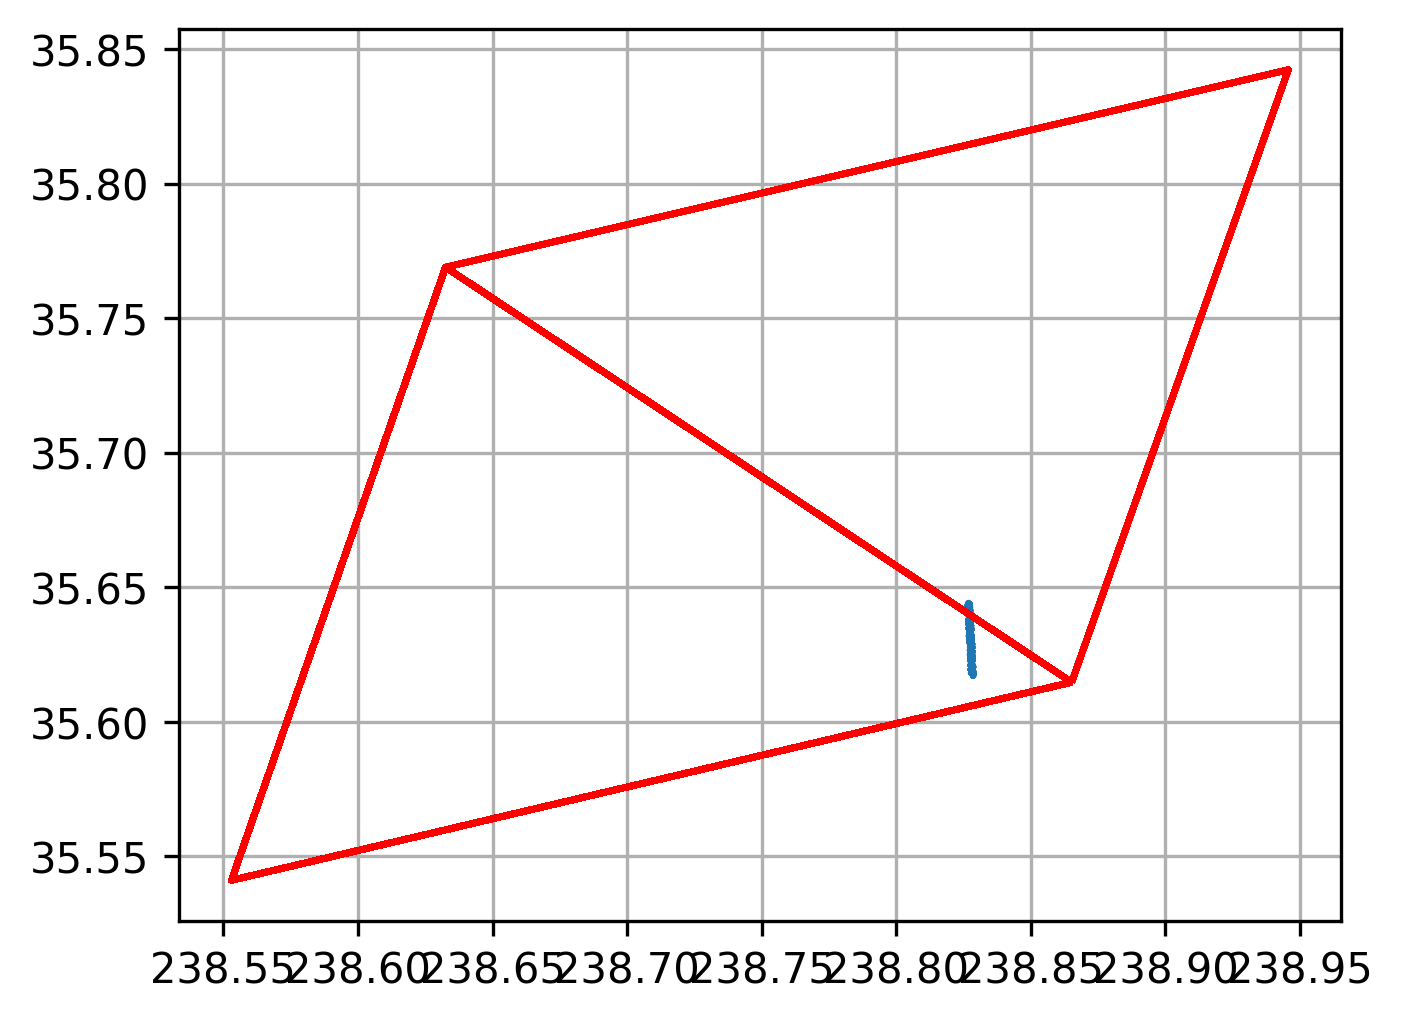

In [49]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.grid(True)

joined.set_trixels('trixels_left').plot(ax=ax)
joined.set_trixels('trixels_right').plot(ax=ax, color='r')